In [ ]:
import pandas as pd
import turtle as tr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


Region → Регион

Country → Страна

Item Type → Тип товара

Sales Channel → Канал продаж

Order Priority → Приоритет заказа

Order Date → Дата заказа

Order ID → ID заказа

Ship Date → Дата отгрузки

Units Sold → Количество проданных единиц

Unit Price → Цена за единицу

Unit Cost → Себестоимость единицы

Total Revenue → Общая выручка

Total Cost → Общая себестоимость

Total Profit → Общая прибыль

In [28]:
df = pd.read_csv('alba_1.csv')

df.head(10)

print(df.info())
print(df.describe())

print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          10000 non-null  object 
 1   Country         10000 non-null  object 
 2   Item Type       10000 non-null  object 
 3   Sales Channel   10000 non-null  object 
 4   Order Priority  10000 non-null  object 
 5   Order Date      10000 non-null  object 
 6   Order ID        10000 non-null  int64  
 7   Ship Date       10000 non-null  object 
 8   Units Sold      10000 non-null  int64  
 9   Unit Price      10000 non-null  float64
 10  Unit Cost       10000 non-null  float64
 11  Total Revenue   10000 non-null  float64
 12  Total Cost      10000 non-null  float64
 13  Total Profit    10000 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 1.1+ MB
None
           Order ID    Units Sold    Unit Price     Unit Cost  Total Revenue  \
count  1.000000e+04  1000

Описательная статистика. Units Sold: 2873 → Сильная изменчивость размеров заказов.
Total Profit: $377K → Большие различия в прибыли между заказами. Пропусков данных нет 

In [29]:
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df["Ship Date"] = pd.to_datetime(df["Ship Date"], errors="coerce")

# типо че по пропускам попускам 
missing_values = df.isnull().sum()


numeric_columns = ["Units Sold", "Unit Price", "Unit Cost", "Total Revenue", "Total Cost", "Total Profit"] #чтобы житие легче было 
df_numeric = df[numeric_columns].dropna()  # Удаляем строки с пропусками

# нормальное распределение (четкие ли челы?)
normality_tests = {col: stats.shapiro(df_numeric[col]) for col in numeric_columns}

missing_values, normality_tests

/Users/maksim/PycharmProjects/pythonProject4/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.



(Region            0
 Country           0
 Item Type         0
 Sales Channel     0
 Order Priority    0
 Order Date        0
 Order ID          0
 Ship Date         0
 Units Sold        0
 Unit Price        0
 Unit Cost         0
 Total Revenue     0
 Total Cost        0
 Total Profit      0
 dtype: int64,
 {'Units Sold': ShapiroResult(statistic=np.float64(0.9564601737759267), pvalue=np.float64(2.598341660374719e-47)),
  'Unit Price': ShapiroResult(statistic=np.float64(0.8554461208566402), pvalue=np.float64(9.943315399252918e-70)),
  'Unit Cost': ShapiroResult(statistic=np.float64(0.8139090806440938), pvalue=np.float64(5.128365058317335e-75)),
  'Total Revenue': ShapiroResult(statistic=np.float64(0.8034849526405978), pvalue=np.float64(3.4916877350692874e-76)),
  'Total Cost': ShapiroResult(statistic=np.float64(0.7584387136660428), pvalue=np.float64(1.0982928433592908e-80)),
  'Total Profit': ShapiroResult(statistic=np.float64(0.8678058275170981), pvalue=np.float64(6.625160792882018e-6


По тесту САМОГО ШАПИРА-УИЛКА мы выяснили, что все p-value < 0.05, а значит  распределён нормально
как сказал инет, лучше делать непараметрические данные 
В дальнейшем построим линейную регрессию 



In [30]:
df.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,Chad,Office Supplies,Online,L,2011-01-27,292494523,2011-02-12,4484,651.21,524.96,2920025.64,2353920.64,566105.00
1,Europe,Latvia,Beverages,Online,C,2015-12-28,361825549,2016-01-23,1075,47.45,31.79,51008.75,34174.25,16834.50
2,Middle East and North Africa,Pakistan,Vegetables,Offline,C,2011-01-13,141515767,2011-02-01,6515,154.06,90.93,1003700.90,592408.95,411291.95
3,Sub-Saharan Africa,Democratic Republic of the Congo,Household,Online,C,2012-09-11,500364005,2012-10-06,7683,668.27,502.54,5134318.41,3861014.82,1273303.59
4,Europe,Czech Republic,Beverages,Online,C,2015-10-27,127481591,2015-12-05,3491,47.45,31.79,165647.95,110978.89,54669.06


In [31]:

# Гистограммы + KDE
fig1 = px.histogram(df_numeric, x="Total Profit", marginal="box", nbins=50, title="Распределение прибыли")
fig2 = px.histogram(df_numeric, x="Total Revenue", marginal="box", nbins=50, title="Распределение выручки")


# Вывод графиков Plotly
fig1.show()
fig2.show()


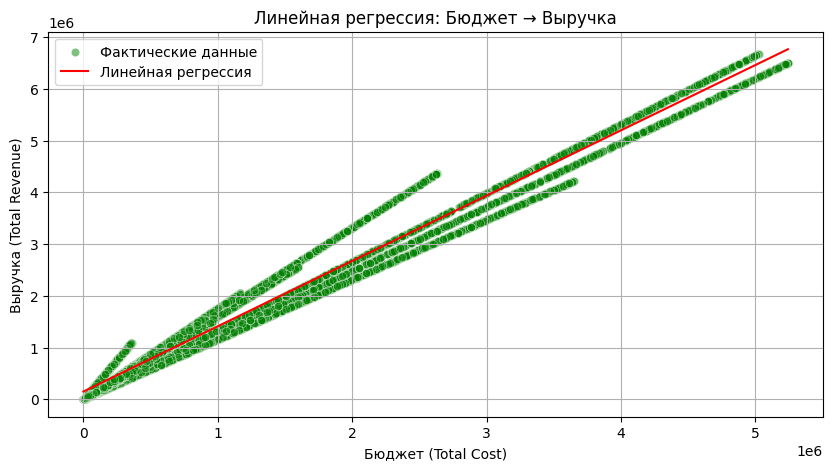

(np.float64(1.262974969827416),
 np.float64(148348.93089265237),
 0.9758943934740882,
 174915.81525781227,
 51732730242.10736)

In [32]:
df_regression = df_numeric.copy()
df_regression["Budget"] = df_regression["Total Cost"]  
df_regression["Выручка"] = df_regression["Total Revenue"]
# статс модель


X = df_regression[["Budget"]]
y = df_regression["Выручка"]


model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

coef = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

plt.figure(figsize=(10, 5))
sns.scatterplot(x=X["Budget"], y=y, color='green', alpha=0.5, label="Фактические данные")
sns.lineplot(x=X["Budget"], y=y_pred, color='red', label="Линейная регрессия")
plt.xlabel("Бюджет (Total Cost)")
plt.ylabel("Выручка (Total Revenue)")
plt.title("Линейная регрессия: Бюджет → Выручка")
plt.legend()
plt.grid()
plt.show()

coef, intercept, r2, mae, mse


coef – коэффициент наклона (показывает, насколько изменится выручка при изменении затрат на 1 единицу).

intercept – свободный член (точка пересечения с осью Y, то есть "начальная выручка" при нулевых затратах).

r2 – коэффициент детерминации (качество модели, насколько хорошо регрессия описывает данные, от 0 до 1).

mae – средняя абсолютная ошибка (насколько в среднем предсказания отличаются от фактических значений).

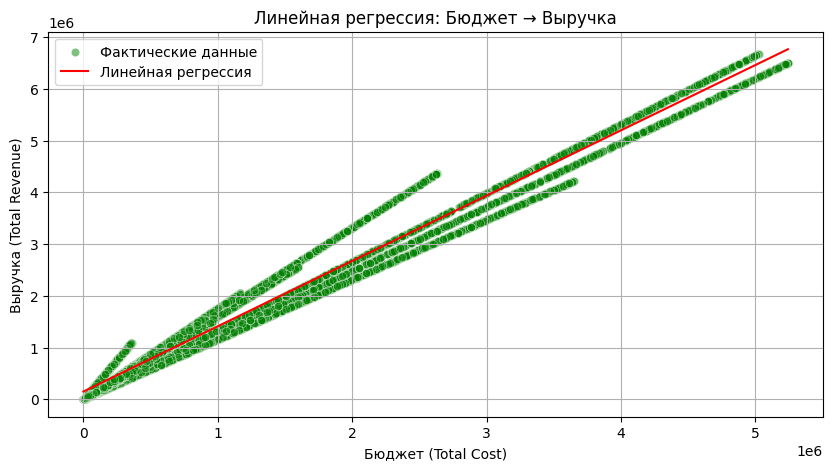

                            OLS Regression Results                            
Dep. Variable:                Выручка   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 4.048e+05
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:52:06   Log-Likelihood:            -1.3754e+05
No. Observations:               10000   AIC:                         2.751e+05
Df Residuals:                    9998   BIC:                         2.751e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.483e+05   2940.003     50.459      0.0

(148348.9308926572,
 1.2629749698274106,
 0.9758943934740882,
 174915.81525781317,
 51732730242.10736)

In [33]:


df_regression = df_numeric.copy()
df_regression["Budget"] = df_regression["Total Cost"]  
df_regression["Выручка"] = df_regression["Total Revenue"]

X = df_regression[["Budget"]]
y = df_regression["Выручка"]
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit()


y_pred = model.predict(X)

intercept, coef = model.params
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

# График
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_regression["Budget"], y=y, color='green', alpha=0.5, label="Фактические данные")
sns.lineplot(x=df_regression["Budget"], y=y_pred, color='red', label="Линейная регрессия")
plt.xlabel("Бюджет (Total Cost)")
plt.ylabel("Выручка (Total Revenue)")
plt.title("Линейная регрессия: Бюджет → Выручка")
plt.legend()
plt.grid()
plt.show()

# Вывод результатов
print(model.summary())
(intercept, coef, r2, mae, mse)

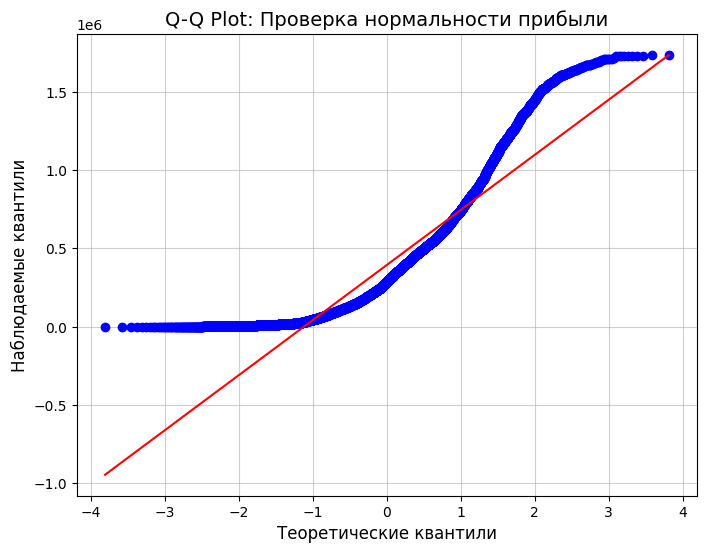

In [34]:

data = df["Total Profit"]


plt.figure(figsize=(8, 6))
stats.probplot(data, dist="norm", plot=plt)


plt.title("Q-Q Plot: Проверка нормальности прибыли", fontsize=14)
plt.xlabel("Теоретические квантили", fontsize=12)
plt.ylabel("Наблюдаемые квантили", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.6)

plt.show()

In [35]:

corr_matrix = df.select_dtypes(include=[np.number]).corr()

fig6 = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,  
    x=corr_matrix.columns,  
    y=corr_matrix.columns,  
    colorscale='RdBu',  
    zmin=-1, 
    zmax=1, 
    hoverongaps=False  
))
fig6.update_layout(title='Матрица корреляций числовых показателей')
# fig6.write_html('6.html')
fig6.show()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
df['Processing Time'] = (df['Ship Date'] - df['Order Date']).dt.days
fig1 = px.histogram(df, x='Processing Time', nbins=30, 
                   title='Распределение времени обработки заказов',
                   labels={'Processing Time': 'Дни обработки'},
                   color_discrete_sequence=['#636EFA'])
fig1.update_layout(bargap=0.1)
fig1.show()



In [36]:
fig2 = px.box(df, x='Region', y='Total Profit', 
             title='Распределение прибыли по регионам',
             color='Region')
fig2.update_layout(xaxis_title='Регион', yaxis_title='Прибыль')
fig2.show() 
# сравнить по anova однофакторную тест Тьюки
fig = px.violin(
    df,
    x='Region',
    y='Total Profit',
    color='Region',                    
    box=True,                         
    points='all',                      
    hover_data=['Sales Channel'],       
    title='Распределение прибыли по регионам',
    labels={'Total Profit': 'Прибыль (USD)', 'Region': 'Регион'},
    height=800,
    width=1200
)

fig.update_layout(
    xaxis_title='Регион',
    yaxis_title='Прибыль',
    font=dict(size=12),
    showlegend=False,                   
    hovermode='x unified',              
)



fig.show()

ХИХИ( квадрат...

In [37]:



contingency_table = pd.crosstab(df['Region'], df['Sales Channel'])

# Вывод таблицы сопряженности
print("Таблица сопряженности:")
print(contingency_table)

# Проведение теста хи-квадрат
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2_stat:.3f}")
print(f"p-value: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Есть статистически значимая зависимость между Region и Sales Channel.")
else:
    print("Нет статистически значимой зависимости между Region и Sales Channel.")


Таблица сопряженности:
Sales Channel                      Offline  Online
Region                                            
Asia                                   708     761
Australia and Oceania                  373     424
Central America and the Caribbean      517     502
Europe                                1318    1315
Middle East and North Africa           625     639
North America                          109     106
Sub-Saharan Africa                    1289    1314
Chi-squared Statistic: 4.349
p-value: 0.6295355543896812
Нет статистически значимой зависимости между Region и Sales Channel.


ANOVA


In [ ]:
grouped = [df[df['Region'] == region]['Total Profit'] for region in df['Region'].unique()]

f_stat, p_value = stats.f_oneway(*grouped)

# Вывод результата
print(f"ANOVA F-statistic: {f_stat}")
print(f"ANOVA p-value: {p_value}")

# Интерпретация
if p_value < 0.1:
    print("Есть статистически значимая разница между регионами.")
else:
    print("Нет статистически значимой разницы между регионами.")

ANOVA F-statistic: 1.8687796145485975
ANOVA p-value: 0.08213843246146027
Нет статистически значимой разницы между регионами.


Тест Тьюки 
Критерий назван так в честь предложившего его американского математика и статистика Джона Тьюки (John Tukey). Критерий Тьюки используется для проверки нулевой гипотезы H0:μB=μA H 0 : μ B = μ A против альтернативной гипотезы H0:μB≠μA H 0 : μ B ≠ μ A , где индексы A и B обозначают любые две сравниваемые группы

In [40]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Проведение Теста Тьюки
tukey_result = pairwise_tukeyhsd(endog=df['Total Profit'], 
                                 groups=df['Region'], 
                                 alpha=0.1)

# Вывод результатов Теста Тьюки
print(tukey_result.summary())


                                 Multiple Comparison of Means - Tukey HSD, FWER=0.10                                  
              group1                            group2                meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------------------------------------------------------------
                             Asia             Australia and Oceania   6747.7188 0.9997  -37974.1244   51469.562  False
                             Asia Central America and the Caribbean  -4029.1495    1.0  -45472.7042  37414.4052  False
                             Asia                            Europe   -9816.871 0.9852  -42921.6963  23287.9544  False
                             Asia      Middle East and North Africa   3554.7054    1.0  -35445.3462   42554.757  False
                             Asia                     North America  62903.7405 0.2526  -11324.7649  137132.246  False
                             Asia               